# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:



**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income



In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
#reversing a table
#portfolio.iloc[::-1]

Examining portfolio table

**portfolio.json**

It contains 10 rows and 6 columns.
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO (buy one get one free), discount, informational (no monetary reward)
* difficulty (int) - minimum required spend to complete an offer, in dollars
* reward (int) - reward given for completing an offer, in dollars
* duration (int) - time for offer to be open, in days
* channels (list of strings) - how the offer is communicated (email, mobile, social, web)




In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [7]:
portfolio.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


I note that every single channel includes 'email'. So we wont be able to analyse the impact of sending an email.

In [9]:
portfolio.channels.str.join(" ").str.contains("email")

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: channels, dtype: bool

In [10]:
#for row in portfolio.channels:
#    row.remove('email')

All id's are unique

In [11]:
portfolio.groupby(['id']).size()
portfolio.id.nunique()


10

There are 4 bogo types of offer, 4 discounts and 2 infomational.

In [12]:
portfolio.groupby(['offer_type']).size()

offer_type
bogo             4
discount         4
informational    2
dtype: int64

Below is the breakdown when reward size is included

In [13]:
portfolio.groupby(['offer_type','reward']).size()

offer_type     reward
bogo           5         2
               10        2
discount       2         2
               3         1
               5         1
informational  0         2
dtype: int64

Below is the breakdown when difficulty is added

In [14]:
portfolio.groupby(['offer_type','reward','difficulty']).size()

offer_type     reward  difficulty
bogo           5       5             2
               10      10            2
discount       2       10            2
               3       7             1
               5       20            1
informational  0       0             2
dtype: int64

Below is the breakdown when duration is added

In [15]:
portfolio.groupby(['offer_type','reward','difficulty','duration']).size()

offer_type     reward  difficulty  duration
bogo           5       5           5           1
                                   7           1
               10      10          5           1
                                   7           1
discount       2       10          7           1
                                   10          1
               3       7           7           1
               5       20          10          1
informational  0       0           3           1
                                   4           1
dtype: int64

That is a simple to read breakdown of the 10 offer types. Each have a distinct id.

The channel type is a nested column. So I can expand this field out if I want to try to determine the influence each media channel has within an offer. Although I will need to add a tag to the id field or have a have a way of tracking this for later analysis

**profile.json**

It contains 17000 rows and 5 columns
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

 Although 2175 rows have age with value set to 118 which represents a missing value. The gender and income fields are also missing values on the rows where age is 118. I suspect these will not be useful during the analysis and will need to be filtered out.

In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [17]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


All ids are unique

In [18]:
profile.id.nunique() == len(profile)

True

I can see there is some missing data for gender and income. Also there seems to be lots of ages=118. 

There is the exact same number of gender and income nulls. Which leads me to think (and hope) they are directly related

In [19]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There is also the 2175 values where age is 118. This leads me to believe that 118 is a filler value for a null age value.

In [20]:
len(profile.loc[profile['age'] == 118])

2175

I will confirm that the nulls in gender and income and the 118 value for age all occur for the same values. And as shown below all null values do indeed occur when age is 118.

In [21]:
(profile.loc[profile['age'] == 118]).isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

A more effecient way of checking all null values are on the same rows

In [22]:

(profile.gender.isna()==(profile.income.isna())).all()

True

In [23]:
##This also works
##profile.gender.isna().isin(profile.age == 118).all()

(profile.gender.isna()==(profile.age == 118)).all()

True

The only information left in the rows with the nulls is the id and the date they became a member. I will filter these values out for now. Perhaps later I can imput this data by comparing to the transcript table and seeing if the id's appear there.

The highest age remaining is 101 which is a more believable maximum age.

In [24]:
profile.loc[profile['age'] != 118].age.max()

101

A minimum age of 18 is also believable.

In [25]:
profile.loc[profile['age'] != 118].age.min()

18

Creating a histogram of age to check it looks reasonable

<AxesSubplot:>

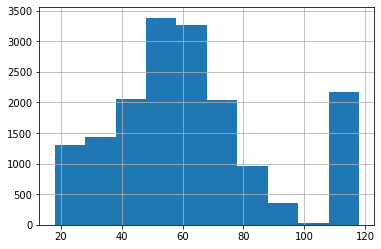

In [26]:
profile.age.hist()

In [27]:
profile.age

0        118
1         55
2        118
3         75
4        118
        ... 
16995     45
16996     61
16997     49
16998     83
16999     62
Name: age, Length: 17000, dtype: int64

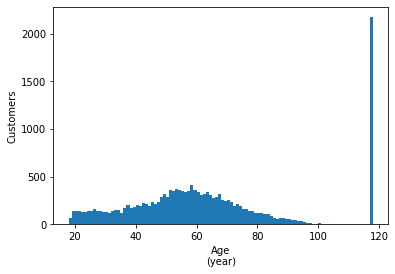

In [28]:
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

##suitable number of bins is max age minus min age (age range)
bins=profile.age.max()-profile.age.min()
profile.age.hist(bins=bins)

axs.set_ylabel('Customers')
axs.set_xlabel('Age\n(year)')
axs.grid(False)

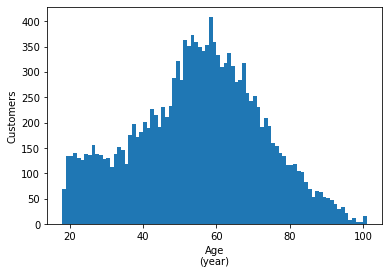

In [29]:
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

##suitable number of bins is max age minus min age (age range)
is_good_age = profile.age != 118
bins=profile.loc[is_good_age ].age.max()-profile.loc[is_good_age ].age.min()
profile.loc[is_good_age ].age.hist(bins=bins)

axs.set_ylabel('Customers')
axs.set_xlabel('Age\n(year)')
axs.grid(False)

In [30]:
val=len(profile.loc[profile['age'] == 118])/len(profile['age'])
round(val,4)

0.1279

max and min incomes are within a reasonable range

In [31]:
profile.income.max()

120000.0

In [32]:
profile.income.min()

30000.0

Creating a histogram of income to check it looks reasonable

<AxesSubplot:>

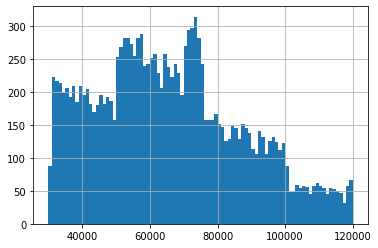

In [33]:
profile.income.hist(bins=90)

There is plenty more men than female in this study. But that is not an issue. There are a few non male nor female genders too.

<AxesSubplot:ylabel='gender'>

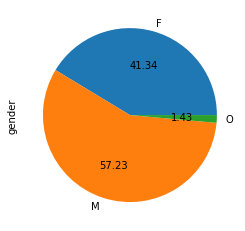

In [34]:
profile.groupby(['gender']).size().plot.pie( shadow=False, autopct="%.2f", figsize=(4, 4), ylabel='gender')

<AxesSubplot:ylabel='person'>

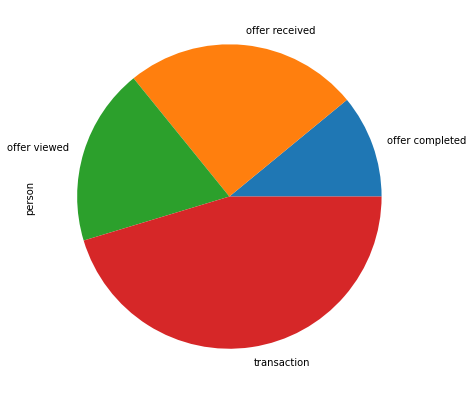

In [35]:
transcript.groupby(['event']).count().person.plot.pie( figsize=(7, 7))

Plot age for each gender

In [36]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


array([[<AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'O'}>, <AxesSubplot:>]], dtype=object)

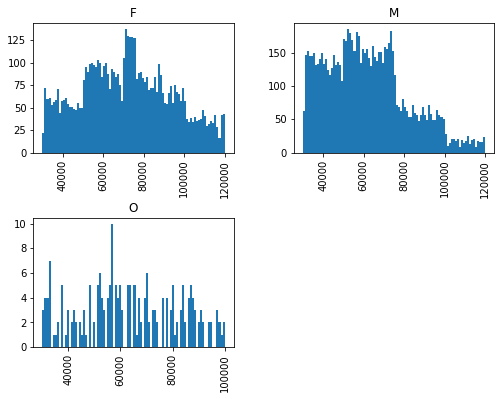

In [37]:
profile['income'].hist(bins=90,by=profile['gender'],figsize=(8,6))


Became member on

In [38]:
profile.became_member_on.max()

20180726

In [39]:
profile.became_member_on.min()

20130729

Examining the dates that users became a member to make sure they seem to fall in a reasonable time range

Converting each value that a user became a member to a 6 figure int holding the year and month they joined.

In [40]:
dates=profile.became_member_on.astype(str)

months=[]

for date in dates:
    month = date[:6] 
    month=int(month)
    months.append(month)


In [41]:
from collections import Counter

pd.Series(Counter(sorted(months)))

201307      5
201308     68
201309     57
201310     56
201311     48
         ... 
201803    618
201804    585
201805    601
201806    562
201807    506
Length: 61, dtype: int64

The Spread of the joiners seem reasonable to me with no suspicious outliers

<AxesSubplot:>

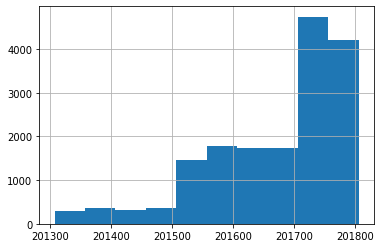

In [42]:
pd.Series(months).hist()

Tidier way of getting the dates converted to dates for graphing

In [43]:
member_dates=pd.to_datetime(profile.became_member_on, format='%Y%m%d')
member_dates

0       2017-02-12
1       2017-07-15
2       2018-07-12
3       2017-05-09
4       2017-08-04
           ...    
16995   2018-06-04
16996   2018-07-13
16997   2017-01-26
16998   2016-03-07
16999   2017-07-22
Name: became_member_on, Length: 17000, dtype: datetime64[ns]

In [397]:
pd.to_datetime(member_dates).view(int)/ 10**9

0        1.486858e+09
1        1.500077e+09
2        1.531354e+09
3        1.494288e+09
4        1.501805e+09
             ...     
16995    1.528070e+09
16996    1.531440e+09
16997    1.485389e+09
16998    1.457309e+09
16999    1.500682e+09
Name: became_member_on, Length: 17000, dtype: float64

<AxesSubplot:>

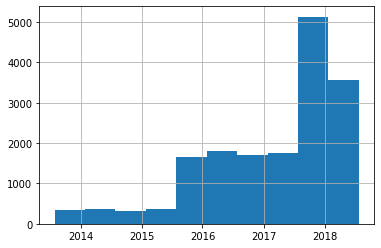

In [45]:
member_dates.hist()

In [46]:
member_dates.dt.year

0        2017
1        2017
2        2018
3        2017
4        2017
         ... 
16995    2018
16996    2018
16997    2017
16998    2016
16999    2017
Name: became_member_on, Length: 17000, dtype: int64

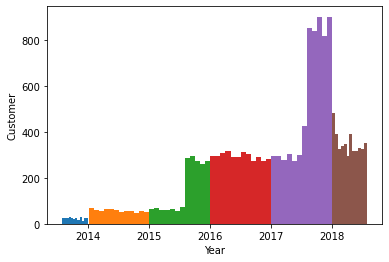

In [47]:
## Generate histograms
bins = 12
fig2, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

member_dates.groupby(member_dates.dt.year) .hist(bins=12)
axs.set_ylabel('Customer')
axs.set_xlabel('Year')
axs.grid(False)

In [48]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


I would have expected a smoother relationship between age and average income

In [49]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Average Income')

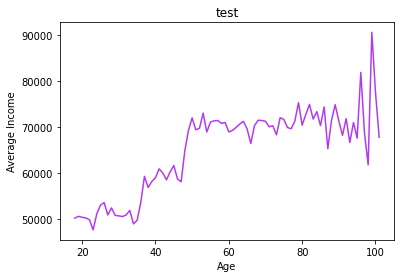

In [50]:
plt.plot(profile.loc[is_good_age].groupby(['age']).income.mean(),color='#B23AEE',linestyle='-')
plt.title('test')
plt.xlabel("Age")
plt.ylabel("Average Income")

In [51]:
profile.groupby(['age']).income.mean()

age
18     50228.571429
19     50622.222222
20     50414.814815
21     50285.714286
22     49877.862595
           ...     
98     61800.000000
99     90600.000000
100    77583.333333
101    67800.000000
118             NaN
Name: income, Length: 85, dtype: float64

**transcript.json**

It contains 306534 rows and 4 columns.
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test.
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [52]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [53]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


There are no null values.

In [54]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Inspecting the person column in transcript. I can see the average person has multiple occurances in the dataset.

In [55]:
(transcript.groupby('person').count())

,event,value,time
person,,,
0009655768c64bdeb2e877511632db8f,20,20,20
00116118485d4dfda04fdbaba9a87b5c,7,7,7
0011e0d4e6b944f998e987f904e8c1e5,18,18,18
0020c2b971eb4e9188eac86d93036a77,19,19,19
0020ccbbb6d84e358d3414a3ff76cffd,23,23,23
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,23,23,23
fff7576017104bcc8677a8d63322b5e1,18,18,18
fff8957ea8b240a6b5e634b6ee8eafcf,10,10,10


The average person occurs over 18 times

In [56]:
(transcript.groupby('person').count()).mean()

event    18.031412
value    18.031412
time     18.031412
dtype: float64

This is the same length of the profile table. So I suspect all ids in the profile table occur in transcript. 

In [57]:
len(transcript.groupby('person').count())

17000

Can confirm the transcript.person and profile.id contain identical ids

In [58]:
len( list(set(transcript['person']) & set(profile['id'])))

17000

Spot checking one value. I can see it has multiple different events.

In [59]:

transcript.loc[transcript['person']=='00116118485d4dfda04fdbaba9a87b5c']


,person,event,value,time
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
85769,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},216
104088,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.7000000000000001},294
187632,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.2},456
193680,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 3.19},474
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576
284472,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},630


Although this is one of the values I intend to filter out. But perhaps I could use random forest algorithm to estimate the missing data

In [60]:
profile.loc[profile['id']=='00116118485d4dfda04fdbaba9a87b5c']

,gender,age,id,became_member_on,income
4434,None,118,00116118485d4dfda04fdbaba9a87b5c,20180425,NaN


The below example does have good data in the profile table and will be used during training/test. They have plenty of solid data explaining offers they recieved or viewed or completed. And of the transactions they made.

In [61]:

transcript.loc[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408
168412,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504


In [62]:
profile.loc[profile['id']=='0009655768c64bdeb2e877511632db8f']

,gender,age,id,became_member_on,income
3793,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0


The time column isnt as uniform as I expected. But I dont see it as an obvious issue. 

In [63]:
transcript.groupby('time').count().sort_values(by=['value'])

,person,event,value
time,,,
150,894,894,894
162,910,910,910
156,914,914,914
330,938,938,938
318,940,940,940
...,...,...,...
168,16150,16150,16150
336,16302,16302,16302
504,16822,16822,16822


The max time is 714 hours. So indicates that the timespan of the data is about a month.

In [64]:
display(transcript.time.min())
display(transcript.time.max())

0

714

There are 6 very distinct peaks that appear quite odd. And the data seems to tail off after each peak until the next peak is hit. I dont think these peaks are natural. It could be possible that the transactions have a lag before being processed. But if that is the case then it becomes a lot of difficult to predict the customer behaviour over time. So I suspect that this data is just an anomoly of how the sample data was generated. In a real world scenario I would contact the collector of the data and ask if these peaks can be explained.

Can ignore the section above. Will rewrite that analysis.

Text(0, 0.5, 'Time')

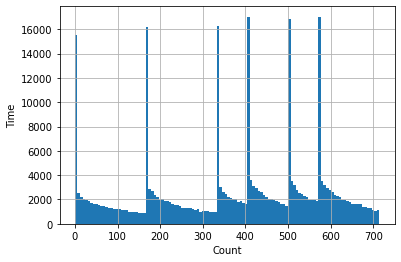

In [65]:
transcript.time.hist(bins=120)
#plt.title('Test')
plt.xlabel("Count")
plt.ylabel("Time")

<AxesSubplot:>

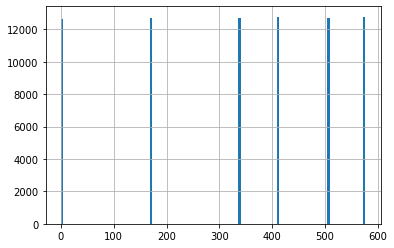

In [66]:
transcript[transcript.event=="offer received"].time.hist(bins=120)

<AxesSubplot:>

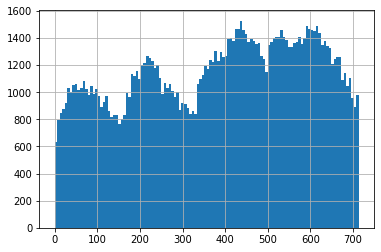

In [67]:
transcript[transcript.event=="transaction"].time.hist(bins=120)

Text(0, 0.5, 'Count')

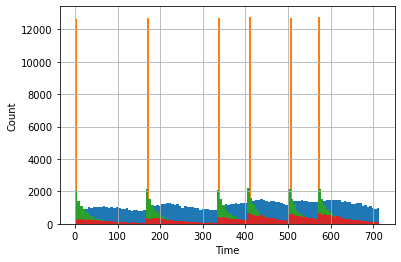

In [68]:
transcript[transcript.event=="transaction"].time.hist(bins=120)
transcript[transcript.event=="offer received"].time.hist(bins=120)
transcript[transcript.event=="offer viewed"].time.hist(bins=120)
transcript[transcript.event=="offer completed"].time.hist(bins=120)
plt.xlabel("Time")
plt.ylabel("Count")

Less than 11% of the rows are classified as “offer completed”. This may affect how I prepare the data or how I evaluate the model.

In [69]:
#transcript.groupby(['event']).agg('count')
(transcript.groupby(['event']).count())

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


<AxesSubplot:>

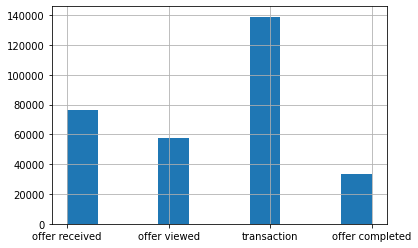

In [70]:
transcript.event.hist()

<AxesSubplot:ylabel='event'>

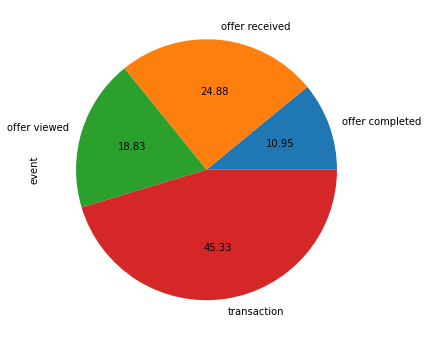

In [71]:
#plt.pie(transcript.event, labels = ['offer recieved','offer viewed','transaction','offer completed'])

transcript.groupby(['event']).count().person.plot.pie( autopct="%.2f", figsize=(6, 6), ylabel='event')

In [72]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


The value column does not always have the same dictionary key. It can be 'amount' or 'offer_id'. It can also have a second nested dictionary in the case that a an offer is completed and a reward given.

In [73]:
transcript.loc[transcript['event']=='transaction']

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [74]:
transcript.loc[transcript['event']=='offer completed'].value[12658]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_records.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pop.html

In [75]:
#resetting transcript
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [76]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [77]:
old_transcript=transcript.groupby('event').count()
old_transcript

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


In [78]:
display(transcript[transcript.event=='offer received'].head(2))
display(transcript[transcript.event=='offer viewed'].head(2))
display(transcript[transcript.event=='offer completed'].head(2))
display(transcript[transcript.event=='transaction'].head(2))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0


,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0


offer completed events have offer_id and reward information. It has an underscore so it is different to offer received and offer viewed. Will need to merge these values later.

In [79]:
transcript.iloc[12658].value

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

So the value column needs to be popped out and manipulated to pull out it's nested dictionaries.

In [80]:
value_col=transcript.pop('value')

In [81]:
value_col.head(10)
value_col.iloc[12658]


{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

from_records is a tidy way of converting several dictionaries to a table as shown in the quick example below

In [82]:
data = [{'col_1': 3, 'col_2': 'a'},
        {'col_1': 2, 'col_3': 'b'},
        {'col_1': 1, 'col_2': 'c'},
        {'col_1': 0, 'col_2': 'd'}]

data

[{'col_1': 3, 'col_2': 'a'},
 {'col_1': 2, 'col_3': 'b'},
 {'col_1': 1, 'col_2': 'c'},
 {'col_1': 0, 'col_2': 'd'}]

In [83]:
pd.DataFrame.from_records(data)


,col_1,col_2,col_3
0,3,a,NaN
1,2,NaN,b
2,1,c,NaN
3,0,d,NaN


In [84]:
#value_col=pd.DataFrame.from_records(value_col)
value_col=pd.DataFrame.from_records(data=value_col,columns=['offer id','offer_id','amount','reward'])

value_col.iloc[12658]

offer id                                 NaN
offer_id    2906b810c7d4411798c6938adc9daaa5
amount                                   NaN
reward                                   2.0
Name: 12658, dtype: object

In [85]:
value_col.head()

,offer id,offer_id,amount,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.update.html  
Modify in place using non-NA values from another DataFrame.
        
combining the offer completed id's (underscore) into the offer received and viewed id's (no underscore)

In [86]:
value_col['offer id'].update(value_col.pop('offer_id'))


Join the transcript table (with the value popped out) with the value field converted into a table.

In [87]:
transcript= transcript.join(value_col)

In [88]:
transcript[transcript.event=='offer completed']

,person,event,time,offer id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0
...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0


I dont want spaces in my column names

In [89]:
transcript.rename(columns={"offer id": "offer_id"},inplace=True)


In [90]:
display(transcript[transcript.event=='offer received'].head(2))
display(transcript[transcript.event=='offer viewed'].head(2))
display(transcript[transcript.event=='offer completed'].head(2))
display(transcript[transcript.event=='transaction'].head(2))

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


,person,event,time,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0


,person,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN


Comparing the new transcript table to the old confirms it was parsed out correctly

In [91]:
display(old_transcript)
display(transcript.groupby(['event']).count())


,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


,person,time,offer_id,amount,reward
event,,,,,
offer completed,33579,33579,33579,0,33579
offer received,76277,76277,76277,0,0
offer viewed,57725,57725,57725,0,0
transaction,138953,138953,0,138953,0


'offer completed' events have 'reward' values  
'offer received' events have 'offer_id' values  
'offer viewed' events have 'offer_id' values  
'transaction' events have 'amount' values

I can see all values have at least a person, event and time value.

In [92]:
transcript.isnull().sum()

person           0
event            0
time             0
offer_id    138953
amount      167581
reward      272955
dtype: int64

Examining the transaction amounts in the transcript table. I can see in the histogram that the data is heavily skewed. Possibly by an outliers close to a value of 1000

<AxesSubplot:>

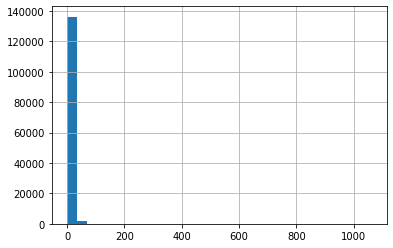

In [93]:
#transcript.amount.dropna.hist(bins=50)
transcript.amount.dropna().hist(bins=30)

In [94]:
pd.cut(transcript.amount.dropna(), 50).value_counts().head()

(-1.012, 21.295]     114621
(21.295, 42.539]      23278
(42.539, 63.784]        433
(63.784, 85.028]         95
(85.028, 106.273]        71
Name: amount, dtype: int64

In [95]:
(transcript.amount).sort_values(ascending=False).dropna()

284273    1062.28
301790    1015.73
42253     1001.85
140346     989.34
302951     977.78
           ...   
298170       0.05
108305       0.05
108315       0.05
108489       0.05
109307       0.05
Name: amount, Length: 138953, dtype: float64

In [96]:
transcript.loc[transcript.amount >1000]

,person,event,time,offer_id,amount,reward
42253,5ecaea5c8bf44ae4a65838d9d066c909,transaction,102,NaN,1001.85,NaN
284273,6cf884a6c5ae4b2daccb6d3108028fef,transaction,630,NaN,1062.28,NaN
301790,454b00bdd77c4f588eb9f6cafd81dc5d,transaction,690,NaN,1015.73,NaN


In [97]:
transcript.loc[transcript.amount >1000 ]

,person,event,time,offer_id,amount,reward
42253,5ecaea5c8bf44ae4a65838d9d066c909,transaction,102,NaN,1001.85,NaN
284273,6cf884a6c5ae4b2daccb6d3108028fef,transaction,630,NaN,1062.28,NaN
301790,454b00bdd77c4f588eb9f6cafd81dc5d,transaction,690,NaN,1015.73,NaN


In [98]:
transcript.loc[transcript.amount<=0.25].groupby(['person']).count().sort_values(by=['event'], axis=0, ascending=False)

,event,time,offer_id,amount,reward
person,,,,,
5b705521de904d9488c950ef75392649,6,6,0,6,0
4e458fc73b004f6896bafd3f7265d0ce,5,5,0,5,0
e939b759b0fc46c5a10563315f01d91e,5,5,0,5,0
afd07f7a88424108bb0a30f66920eadc,5,5,0,5,0
df6fd073309e42ecb1ab53d3daa6e13b,5,5,0,5,0
...,...,...,...,...,...
5ccd41b525974b16aa806a4cb96f66f8,1,1,0,1,0
5ca2620962114246ab218fc648eb3934,1,1,0,1,0
5c77da0f5e12463aaff3215de53b711a,1,1,0,1,0


In [99]:
transcript.loc[(transcript.person=='edbde592cd5e4cdea4af81a398866804')&(transcript.event=='transaction')]

,person,event,time,offer_id,amount,reward
28479,edbde592cd5e4cdea4af81a398866804,transaction,42,NaN,1.00,NaN
31653,edbde592cd5e4cdea4af81a398866804,transaction,54,NaN,7.01,NaN
37395,edbde592cd5e4cdea4af81a398866804,transaction,78,NaN,0.19,NaN
40001,edbde592cd5e4cdea4af81a398866804,transaction,90,NaN,2.20,NaN
44748,edbde592cd5e4cdea4af81a398866804,transaction,114,NaN,2.43,NaN
47950,edbde592cd5e4cdea4af81a398866804,transaction,132,NaN,3.95,NaN
67188,edbde592cd5e4cdea4af81a398866804,transaction,168,NaN,4.53,NaN
70352,edbde592cd5e4cdea4af81a398866804,transaction,174,NaN,3.97,NaN
108305,edbde592cd5e4cdea4af81a398866804,transaction,318,NaN,0.05,NaN
172377,edbde592cd5e4cdea4af81a398866804,transaction,420,NaN,3.74,NaN


In [100]:
transcript.loc[transcript.amount<=.25].groupby(['person']).amount.sum().sort_values( axis=0, ascending=False)

person
5b705521de904d9488c950ef75392649    1.06
640ba8b8068043abb9c6778f8c671950    0.92
f9a4f190f06f47f0b7a581cbe18c0ff4    0.89
82358d808d0d4f19b1d3dcbcb0c16cb1    0.86
afd07f7a88424108bb0a30f66920eadc    0.83
                                    ... 
2c810363d6e2458f82bf4c9030661aa6    0.05
2d6157e5b11646968a5c5062f4fde730    0.05
c2c72ce6038644c797208046d1e3498a    0.05
c2938f6da5f047658f1a6500e86b20b4    0.05
ffede3b700ac41d6a266fa1ba74b4f16    0.05
Name: amount, Length: 1851, dtype: float64

I cant really tell what is causing the small transactions. They could be credit card fees that are processed a while after a valid transaction. They could be a small purchase like a packet of sugar. They could also simply be bad data that should not be in the data set.  

Some starbucks shops do have items available for less than 50cents. But i do find credit card purchases of less than this value suspicious. When I added up the maximum total of purchases for less than 50cents a customer made I got \\$2.48. This is comfortably less than the lowest difficulty of any discount or bogo offer of \\$5. So I don't think they will have a significant impact of misclassifying offers if indeed these transactions are erroneous.  

But if these transactions are not genuine transactions then they could have the unwanted affect of miss classifying informational offers. If they are delayed credit card fees or bad data that occur after a informational offer has been viewed then that informational offer will be classed as positive. So I think I will filter out these transactions from the data preparation phase. I will probably select a threshold of 20cents. I feel this is a safe clause to enter because 20 cents is such a low figure that Starbucks probably would not deem that a successful offer even if they were authentic transactions.

I am also considering cutting off the transactions that were in the hundreds or thousands of dollars. But I am finding this harder to justify. It is very possible that a customer has made a huge purchase like this for their family, friends, or colleagues. And while an offer of \$5 might not seem like an incentive for such a big purchase, it is possible they simple notification or good gesture of an offer was enough for the customer to decide to go to Starbucks that day instead of another chain. For this reason I intend to keep these values in.

https://www.quora.com/What-is-the-least-expensive-thing-to-buy-at-Starbucks-Since-Starbucks-reward-program-gives-you-a-star-for-every-transaction-regardless-of-amount-this-seems-like-a-valuable-bit-of-knowledge

Below is just some playing around with the data to try and get a feel for the distribution and to see if I am missing any other unusual trends in the data.

I see a big drop of around \\$40

In [101]:
pd.cut(transcript.amount.dropna(), 100).value_counts().head()

(-1.012, 10.672]    76299
(10.672, 21.295]    38322
(21.295, 31.917]    19311
(31.917, 42.539]     3967
(42.539, 53.162]      384
Name: amount, dtype: int64

In [102]:
transcript.loc[transcript.amount <40 ]

,person,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN


<AxesSubplot:>

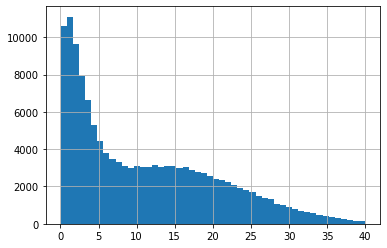

In [103]:
transcript.loc[transcript.amount <40 ].amount.hist(bins=50)

In [104]:
transcript.groupby('amount').count().head(10)

,person,event,time,offer_id,reward
amount,,,,,
0.05,431,431,431,0,0
0.06,109,109,109,0,0
0.07,89,89,89,0,0
0.08,100,100,100,0,0
0.09,87,87,87,0,0
0.10,95,95,95,0,0
0.11,99,99,99,0,0
0.12,79,79,79,0,0
0.13,97,97,97,0,0


In [105]:
transcript.groupby('amount').count().tail(10)

,person,event,time,offer_id,reward
amount,,,,,
947.43,1,1,1,0,0
957.15,1,1,1,0,0
961.21,1,1,1,0,0
962.10,1,1,1,0,0
966.24,1,1,1,0,0
977.78,1,1,1,0,0
989.34,1,1,1,0,0
1001.85,1,1,1,0,0
1015.73,1,1,1,0,0


In [106]:
#z-scores only work on normal distributions
#transcript.loc[np.abs(stats.zscore(transcript['amount'],nan_policy='omit'))<=1]


In [107]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


it is almost a log normal distribution

<AxesSubplot:>

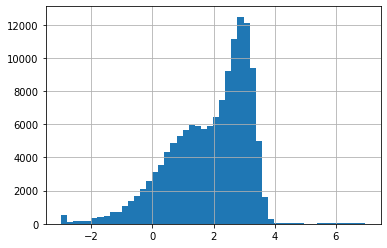

In [108]:
np.log(transcript[transcript['event']=='transaction'].amount).hist(bins=50)

Clipping the data

array([[<AxesSubplot:title={'center':'amount'}>]], dtype=object)

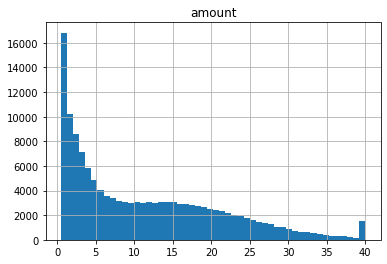

In [109]:
pd.DataFrame(transcript[transcript['event']=='transaction'].amount).clip(0.5, 40).hist(bins=50)

In [110]:
transcript.groupby('offer_id').count()

,person,event,time,amount,reward
offer_id,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,13751,13751,13751,0,3420
2298d6c36e964ae4a3e7e9706d1fb8c2,20139,20139,20139,0,5156
2906b810c7d4411798c6938adc9daaa5,15767,15767,15767,0,4017
3f207df678b143eea3cee63160fa8bed,11761,11761,11761,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,18222,18222,18222,0,3331
5a8bc65990b245e5a138643cd4eb9837,14305,14305,14305,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,16202,16202,16202,0,4354
ae264e3637204a6fb9bb56bc8210ddfd,18062,18062,18062,0,3688
f19421c1d4aa40978ebb69ca19b0e20d,19131,19131,19131,0,4296


In [111]:
#transcript.groupby('offer_id').count().plot(kind='pie', labels=['','','',''],  y='event',ax=axes[0], title='event', fontsize=10)

Renaming id column in portfolio to match the offer_id column in transcript

In [112]:
portfolio.rename(columns={"id": "offer_id"},inplace=True)

In [113]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [114]:
transcript.groupby('offer_id').count()

,person,event,time,amount,reward
offer_id,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,13751,13751,13751,0,3420
2298d6c36e964ae4a3e7e9706d1fb8c2,20139,20139,20139,0,5156
2906b810c7d4411798c6938adc9daaa5,15767,15767,15767,0,4017
3f207df678b143eea3cee63160fa8bed,11761,11761,11761,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,18222,18222,18222,0,3331
5a8bc65990b245e5a138643cd4eb9837,14305,14305,14305,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,16202,16202,16202,0,4354
ae264e3637204a6fb9bb56bc8210ddfd,18062,18062,18062,0,3688
f19421c1d4aa40978ebb69ca19b0e20d,19131,19131,19131,0,4296


Text(0, 0.5, 'Average Income')

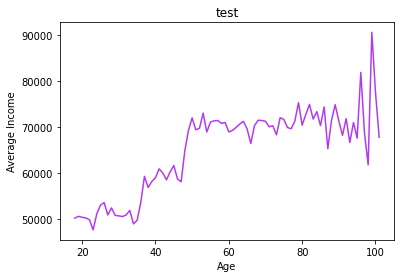

In [115]:
plt.plot(profile.loc[profile['age'] != 118].groupby(['age']).income.mean(),color='#B23AEE',linestyle='-')
plt.title('test')
plt.xlabel("Age")
plt.ylabel("Average Income")

Trying to join

In [116]:
transcript.groupby('offer_id').event.count()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
2906b810c7d4411798c6938adc9daaa5    15767
3f207df678b143eea3cee63160fa8bed    11761
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
5a8bc65990b245e5a138643cd4eb9837    14305
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
ae264e3637204a6fb9bb56bc8210ddfd    18062
f19421c1d4aa40978ebb69ca19b0e20d    19131
fafdcd668e3743c1bb461111dcafc2a4    20241
Name: event, dtype: int64

<AxesSubplot:ylabel='Offer Type'>

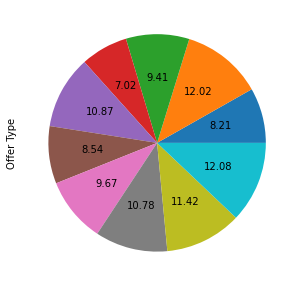

In [117]:
transcript.groupby('offer_id').count().event.plot.pie(ylabel='Offer Type',labels=None, autopct="%.2f", figsize=(5, 5))

In [118]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [119]:
transcript.head(10)

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


JOINING TRANSCRIPT AND PORTFOLIO

In [120]:
transcript

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN


In [121]:
#renaming reward to reward_recieved in transcript so there isnt a conflict. I 
transcript.rename(columns={"offer id": "offer_id"},inplace=True)


In [122]:
#think how i want to handle rewards in a moment
#transcript_portfolio=transcript.merge(portfolio,left_on=('offer_id' ),right_on=('offer_id' ),how='left')

transcript_portfolio=transcript.merge(portfolio,on=('offer_id' ),how='left')

In [123]:
#Instead of removing one of the columns, I am keeping both for now
#renaming reward to reward_recieved from transcript. and reward from portfolio will be kept as reward.
transcript_portfolio.rename(columns={"reward_x": "reward_recieved","reward_y": "reward"},inplace=True)


In [124]:
transcript_portfolio.query('event == "offer received"')


,person,event,time,offer_id,amount,reward_recieved,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo
...,...,...,...,...,...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,10.0,"[email, mobile, social]",10.0,7.0,bogo
257883,cb23b66c56f64b109d673d5e56574529,offer received,576,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,576,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,10.0,"[email, mobile, social]",10.0,7.0,bogo


In [125]:
transcript_portfolio.groupby(['event','offer_id']).person.count()

event            offer_id                        
offer completed  0b1e1539f2cc45b7b9fa7c272da2e1d7    3420
                 2298d6c36e964ae4a3e7e9706d1fb8c2    5156
                 2906b810c7d4411798c6938adc9daaa5    4017
                 4d5c57ea9a6940dd891ad53e9dbe8da0    3331
                 9b98b8c7a33c4b65b9aebfe6a799e6d9    4354
                 ae264e3637204a6fb9bb56bc8210ddfd    3688
                 f19421c1d4aa40978ebb69ca19b0e20d    4296
                 fafdcd668e3743c1bb461111dcafc2a4    5317
offer received   0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
                 2298d6c36e964ae4a3e7e9706d1fb8c2    7646
                 2906b810c7d4411798c6938adc9daaa5    7632
                 3f207df678b143eea3cee63160fa8bed    7617
                 4d5c57ea9a6940dd891ad53e9dbe8da0    7593
                 5a8bc65990b245e5a138643cd4eb9837    7618
                 9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
                 ae264e3637204a6fb9bb56bc8210ddfd    7658
                 f1942

In [126]:
transcript_portfolio.groupby(['offer_id','event']).person.count().unstack()

event,offer completed,offer received,offer viewed
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0
3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0


pie chart showing the share of each event each offer type has

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


array([<AxesSubplot:ylabel='offer completed'>,
       <AxesSubplot:ylabel='offer received'>,
       <AxesSubplot:ylabel='offer viewed'>], dtype=object)

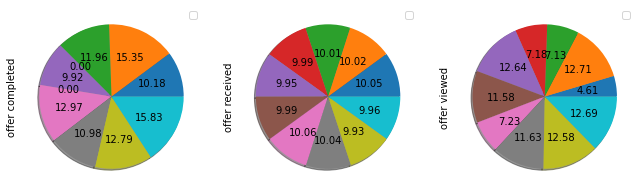

In [127]:
transcript_portfolio.groupby(['offer_id','event']).person.count().unstack().plot.pie(subplots=True, shadow=True, autopct="%.2f",labels=None, figsize=(11, 6))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

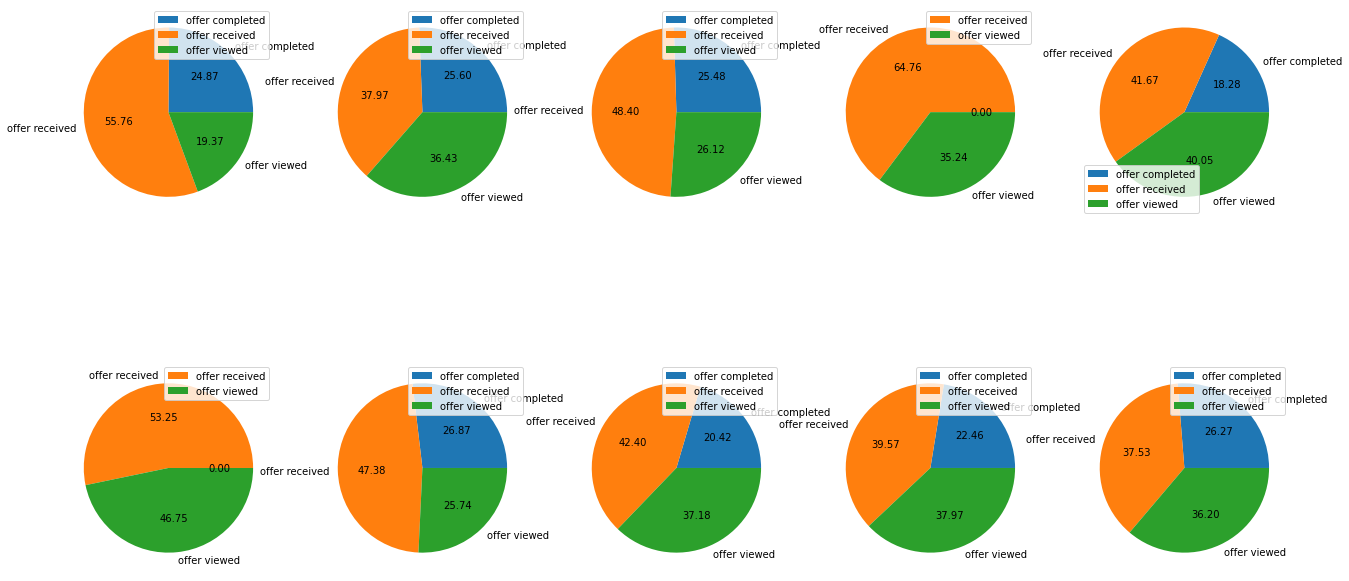

In [128]:
fig, axs = plt.subplots(figsize=(22,12),nrows=2, ncols=5)
transcript_portfolio.groupby(['event','offer_id']).person.count().unstack().plot.pie(ax=axs,subplots=True,autopct="%.2f",ylabel="")



In [129]:
#transcript_portfolio.groupby('offer_id').count()
transcript_portfolio.groupby(['offer_id','event']).person.count().unstack()

event,offer completed,offer received,offer viewed
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0
3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0


joining aggregated data to original portfolio data because I want to graph some correlations

In [130]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [131]:
#transcript_portfolio=transcript.merge(portfolio,on=('offer_id' ),how='left')
event_totals=transcript_portfolio.groupby(['offer_id','event']).person.count().unstack()

portfolio_totals=portfolio.merge(event_totals,how='left',left_on='offer_id',right_on='offer_id')
portfolio_totals

,reward,channels,difficulty,duration,offer_type,offer_id,offer completed,offer received,offer viewed
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,5317.0,7597.0,7327.0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0


I want to have a column with the count of the number of channels per offer. 

Remember I removed email from each entry because it appeared in all entries. So that must be added to the count of each offer to get the true count. (i may have put them back in already, depends)

In [132]:
#portfolio.channels.len()
num_channels=[]

for channel in portfolio.channels:
    num_channels.append(len(channel))
    

In [133]:
channels=pd.Series(num_channels,name='num_channels')
channels

0    3
1    4
2    3
3    3
4    2
5    4
6    4
7    3
8    4
9    3
Name: num_channels, dtype: int64

In [134]:
#portfolio_totals.concat(test, axis = 1)
portfolio_totals=portfolio_totals.join(channels)

In [135]:
cols = list(portfolio_totals.columns.values)
cols

['reward',
 'channels',
 'difficulty',
 'duration',
 'offer_type',
 'offer_id',
 'offer completed',
 'offer received',
 'offer viewed',
 'num_channels']

In [136]:
portfolio_totals=portfolio_totals[['reward',
 'channels',
 'num_channels',
 'difficulty',
 'duration',
 'offer_type',
 'offer_id',
 'offer completed',
 'offer received',
 'offer viewed']]
    

Getting some correlations and graphing

In [138]:
portfolio_totals

,reward,channels,num_channels,difficulty,duration,offer_type,offer_id,offer completed,offer received,offer viewed
0,10,"[email, mobile, social]",3,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
1,10,"[web, email, mobile, social]",4,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
2,0,"[web, email, mobile]",3,0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
3,5,"[web, email, mobile]",3,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
4,5,"[web, email]",2,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
5,3,"[web, email, mobile, social]",4,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
6,2,"[web, email, mobile, social]",4,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,5317.0,7597.0,7327.0
7,0,"[email, mobile, social]",3,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
8,5,"[web, email, mobile, social]",4,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0
9,2,"[web, email, mobile]",3,10,7,discount,2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0


I note that every single channel includes 'email'. So we wont be able to analyse the impact of sending an email.

In [139]:
portfolio_totals.channels.str.join(" ").str.contains("email")


0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: channels, dtype: bool

In [140]:
for row in portfolio_totals.channels:
    row.remove('email')
    

In [141]:
for row in portfolio_totals.channels:
    row.append('email')
    

In [142]:
portfolio_totals

,reward,channels,num_channels,difficulty,duration,offer_type,offer_id,offer completed,offer received,offer viewed
0,10,"[mobile, social, email]",3,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
1,10,"[web, mobile, social, email]",4,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
2,0,"[web, mobile, email]",3,0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
3,5,"[web, mobile, email]",3,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
4,5,"[web, email]",2,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
5,3,"[web, mobile, social, email]",4,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
6,2,"[web, mobile, social, email]",4,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,5317.0,7597.0,7327.0
7,0,"[mobile, social, email]",3,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
8,5,"[web, mobile, social, email]",4,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0
9,2,"[web, mobile, email]",3,10,7,discount,2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0


<font size="5"> Correlations <font/>

Degree of correlation:

* Perfect: If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).  
* High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.  
* Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation.  
* Low degree: When the value lies below + .29, then it is said to be a small correlation.  
* No correlation: When the value is zero.

P-value is the probability that you would find the current result if the correlaton coeffiecient was zero (null hypothesis). If the probability is lower than the conventional 5% then we say the correlation coeffcient is statistically signficant.  


In [143]:
viewed_perc=portfolio_totals['offer viewed']/portfolio_totals['offer received']
completed_perc=portfolio_totals['offer completed']/portfolio_totals['offer received']


the channels have a strong impact on the likelihood of somebody viewing the offer

In [144]:
channel_count=portfolio_totals['num_channels']
#percentage of viewed versus number of channels
correlation, p_value  = stats.pearsonr(viewed_perc, channel_count)

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical signficant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.0017 is less than 0.05 so it seems statistical signficant
Pearson's R (correlation) is: 0.8541559624210716
Explained variation is: 0.7295824081394671


the channel has a much weaker influence on whether or not somebody completes the offer. but still reasonably impactful.

In [145]:
#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(channel_count))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], channel_count[~nas])

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.1514 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.5571201040269655
Explained variation is: 0.3103828103110169


The duration very weakly correlated to the percentage the offer has been viewed. And in fact is slighly negatively correlated. I would have expected this to be a stronger positive relationship.  
Examining some of the values in the table does give me some ideas why this is the case:  
the discount offer with id=0b1e1539f2cc45b7b9fa7c272da2e1d7 has the lowest view rate even though it was available for the joint longest time. I can see the in the channel's column it was only sent via 2 channels. It was not sent via mobile or social. It is possible that mobile and social channels are of very high importance in terms of getting views.

In [146]:
duration_days=portfolio_totals['duration']

#percentage of viewed versus days the offer is available
correlation, p_value  = stats.pearsonr(viewed_perc, duration_days)

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.4755 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: -0.2558799043306762
Explained variation is: 0.065474525440276


the completed percentage versus the duration is also weak. But it is positive at least which makes sense. So while a longer duration doesn't appear to have a strong affect on the liklihood of somebody viewing the offer, it does seem to have some impact on the chances of them completing the offer.

In [147]:
#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(duration_days))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], duration_days[~nas])

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.5525 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.24876204811771904
Explained variation is: 0.06188255658372237


Difficulty -v- completed

The difficulty is reasonably strongly negatively correlated with the likelihood of an offer being completed. As expected.

In [148]:
difficulty_dollars=portfolio_totals['difficulty']

#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(difficulty_dollars))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], difficulty_dollars[~nas])

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.2204 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: -0.4875528284426282
Explained variation is: 0.23770776052240686


The channel column seemed to have the biggest influence on offer viewed. So I will find which channel has most impact on offer viewed/offer completed

In [149]:
portfolio_totals['channels'].isin(['email'])

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: channels, dtype: bool

In [150]:
is_social=[]

for row in portfolio_totals.channels:
    is_social.append('social' in row)

correlation, p_value  = stats.pearsonr(viewed_perc,is_social)

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 6)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 6)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 9e-06 is less than 0.05 so it seems statistical significant
Pearson's R (correlation) is: 0.9614907242619157
Explained variation is: 0.9244644128417032


In [151]:
is_mobile=[]

for row in portfolio_totals.channels:
    is_mobile.append('mobile' in row)

correlation, p_value  = stats.pearsonr(viewed_perc,is_mobile)

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.061 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.6101585759726189
Explained variation is: 0.37229348783293414


In [152]:
is_web=[]

for row in portfolio_totals.channels:
    is_web.append('web' in row)

correlation, p_value  = stats.pearsonr(viewed_perc,is_web)

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 4)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 4)))



print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.4543 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: -0.2678830790282936
Explained variation is: 0.071761344029679


There is no point in trying to get the relationsip between email and offer viewed as every single offer has email in it

There is no obvious correlation with is_social and completed_perc despite the very high relationsip between is_social and viewed_perc

In [153]:

    
#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(is_social))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], pd.Series(is_social)[~nas])



if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 6)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 6)))

    
print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.44977 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.31336648740203304
Explained variation is: 0.09819855542668854


In [154]:

    
#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(is_mobile))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], pd.Series(is_mobile)[~nas])



if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 6)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 6)))

    
print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))

the p_value of 0.287203 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.4303355925677447
Explained variation is: 0.18518872223063196


is probably worth checking correlation between viewed and completed. Because I suspect they arent that highly correlated.

In [155]:
#get from arrays where either has a null (where the offer is just informational)
nas = np.logical_or(np.isnan(completed_perc), np.isnan(viewed_perc))
#perform correlation where neither is a null
correlation, p_value=stats.pearsonr(completed_perc[~nas], pd.Series(viewed_perc)[~nas])

if (p_value)<0.05:
    print("the p_value of {} is less than 0.05 so it seems statistical significant".format(round(p_value, 6)))
else:
    print("the p_value of {} is more than 0.05 so it does not seem statistical significant".format(round(p_value, 6)))

    
print("Pearson's R (correlation) is: {}".format(correlation))
print("Explained variation is: {}".format(correlation**2))


the p_value of 0.294385 is more than 0.05 so it does not seem statistical significant
Pearson's R (correlation) is: 0.42460109046405353
Explained variation is: 0.18028608602326338


As we see above they are positively correlated. But not considered a strong correlation. And it is not statistically significant. This tallies with the narative that has been building through the previous correlations. Higher rates of views does not automatically covert to higher rates of completion.  
It is possible that while users are far more likely to view an offer it pops up on their social media, they are conditioned to ignore adverts like that. While a more targeted offer straight to their mobile or email is more likely to trigger a response once they view it.

<font size=4>Filtering out bad data<font>

I want to see how much data I will be filtering out if I remove all the customers with missing data

if I filter out these values ill be removing 12.8% of the customers 

In [156]:
len(profile.loc[profile['age'] == 118])/len(profile['age'])

0.12794117647058822

In [157]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [158]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [159]:
profile.rename(columns={"id": "person"},inplace=True)

In [160]:
transcript_profile=transcript.merge(profile)

In [161]:
transcript_profile.head()

,person,event,time,offer_id,amount,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,F,75,20170509,100000.0


I will be removing 11.0% of all events

In [162]:
val=len(transcript_profile.loc[transcript_profile['age'] == 118])/len(transcript_profile['age'])
round(val,4)

0.1102

In [163]:
transcript_profile_rec=transcript_profile.loc[transcript_profile['event']=='offer received']
transcript_profile_tran=transcript_profile.loc[transcript_profile['event']=='transaction']

I will be removing 12.8% of total offers sent

In [164]:
len(transcript_profile_rec['age'])

76277

In [165]:
val=len(transcript_profile_rec.loc[transcript_profile_rec['age'] == 118])/len(transcript_profile_rec['age'])
round(val,4)

0.1282

I will be removing 10.8% of total transactions

In [166]:
val=len(transcript_profile_tran.loc[transcript_profile_tran['age'] == 118])/len(transcript_profile_tran['age'])
round(val,4)

0.1079

I think it makes sense to remove these values. Although it possible useful information could be garnered from the customers with missing data. They represent 12.8% of the total customers, and receive 12.8% of the total offers, but they only make 10.8% of total transactions.  
It could be worth leaving these customers in the model and populate the data with dummy information. I could assign them their own seperate gender. It would be difficult to create good dummy data for age and income because they dont have any feature other than the date they became a member on as a guideline. My estimations for these empty values would be pretty rough.   

But for now I am satisfied that I have still a lot of data remaining to work with